In [32]:
from matplotlib import pyplot as plt
import numpy as np 
from os.path import join, abspath 
from hammer import Model
from time import time
import vaex
from scipy.integrate import simps
current = abspath("")
root_dir = abspath(join(current, '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [33]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [34]:
from utils import plot_chain, plot_corner, style, concat

style('ggplot')

In [35]:
baryon_dir = join(root_data_dir, "Baryon")
baryon_dir
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


## Sample

In [36]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 1
a2 = 0.1
atot = a1+a2
a1 = a1/atot
a2 = a2/atot
log_a = np.log(a1)
q_a = a2/a1

psi = concat(rhob, sigmaz, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

rhoDM = 0.016
log_nu0 = 0
zsun = 30

theta = concat(rhoDM, log_nu0, zsun)

theta.shape, psi.shape

((3,), (30,))

In [37]:
psi[25:]

array([-7.        ,  1.60943791,  0.5       , -0.09531018,  0.1       ])

In [38]:
N = 5000

z = np.random.randn(N)*200
w = np.random.randn(N)*15
dz = 1
pos = np.array([z, w]).T
pos.shape

(5000, 2)

In [39]:
pot = Model.DM.fzw(pos, theta,psi, dz)
pot.shape

(5000,)

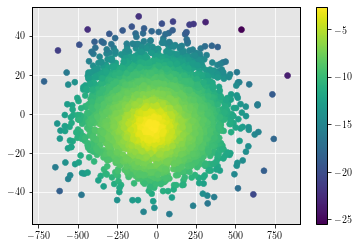

In [40]:
plt.figure(figsize=(6, 4))
plt.scatter(pos[:, 0], pos[:, 1], c=np.log(pot), cmap='viridis')
plt.colorbar()

In [41]:
# number of walkers
N = 16

z = np.random.randn(N)*200
w = np.random.randn(N)*20
dz = 1
pos = np.array([z, w]).T
pos.shape

(16, 2)

In [42]:
nwalkers = pos.shape[0]
ndim = pos.shape[1]

t0 = time()
chain = Model.DM.sample(30_000, nwalkers, pos, theta, psi, dz=1., verbose=True, parallel=True)
print(time() - t0, "s")

51.41045093536377 s


100%|██████████| 2/2 [00:00<00:00, 36.77it/s]


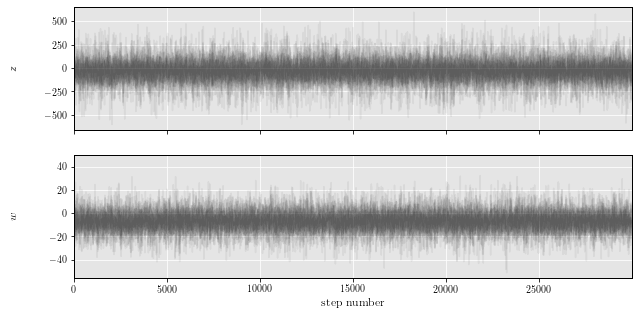

In [43]:
plot_chain(
    chain,
    labels=[r'$z$', r'$w$'],
    figsize=(10, 5),
    alpha=0.05,
) 

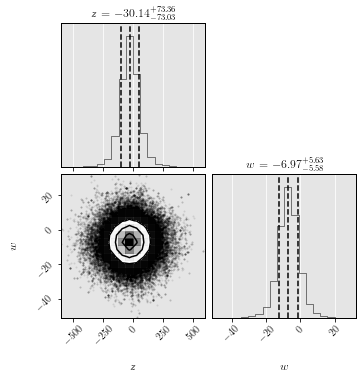

In [44]:
plot_corner(
    params=chain,
    labels=[r'$z$', r'$w$'],
    burn=100,
) 

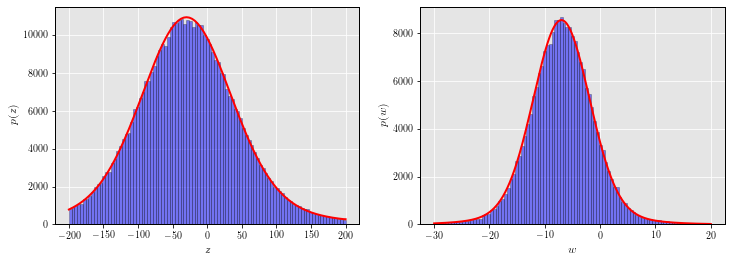

In [45]:
z_sample = chain[:, :, 0].flatten()
w_sample = chain[:, :, 1].flatten()
mask = (z_sample > -50) & (z_sample < 50)
w_sample = w_sample[mask]

z_edge = np.linspace(-200, 200, 100)
dz = z_edge[1] - z_edge[0]
z_mid = (z_edge[:-1] + z_edge[1:])/2
z_num, _ = np.histogram(z_sample, bins=z_edge)
ztot = simps(z_num, z_mid)
zs = np.linspace(z_edge.min(), z_edge.max(), 1000)
fz = Model.DM.fz(zs, theta, psi, dz)
fz = fz * ztot / simps(fz, zs)

w_edge = np.linspace(-30, 20, 100)
dw = w_edge[1] - w_edge[0]
w_mid = (w_edge[:-1] + w_edge[1:])/2
w_num, _ = np.histogram(w_sample, bins=w_edge)
wtot = simps(w_num, w_mid)
ws = np.linspace(w_edge.min(), w_edge.max(), 1000)
fw = Model.DM.fw(ws, theta, psi)
fw = fw * wtot / simps(fw, ws)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(z_mid, z_num, width=dz, color='b', alpha=0.5, ec="k")
axes[0].plot(zs, fz, color='r', lw=2)
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$p(z)$')
axes[1].bar(w_mid, w_num, width=dw, color='b', alpha=0.5, ec="k")
axes[1].plot(ws, fw, color='r', lw=2)
axes[1].set_xlabel(r'$w$')
axes[1].set_ylabel(r'$p(w)$')
plt.show()

# different $z$, $N=5000$

figure out the size of the generated data, using gaussian distribution

In [46]:
def frho(phi, rho0, sigmaz):
    return rho0*np.exp(-phi/sigmaz**2)

def rhob_tot(phi, rhos, sigmaz):
    rho = np.array(list(map(lambda par: frho(phi, par[0], par[1]), zip(rhos, sigmaz))))
    return rho.sum(axis=0)

In [47]:
theta

array([1.6e-02, 0.0e+00, 3.0e+01])

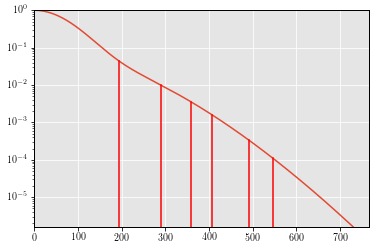

[192.67 289.74 358.15 407.68 490.57 545.22]


In [56]:
from scipy.interpolate import interp1d

dz = 0.01
z = np.arange(-zsun, 700, dz)
phi = Model.DM.potential(z, theta, psi, dz)
z_interp = interp1d(phi, z, kind="cubic")
rhobz = rhob_tot(phi, rhob, sigmaz)

ratio = [0.4, 0.6, 0.8, 1.0, 1.5, 2.0] # rhoDM/rhob
num = len(ratio)
zb = np.empty(num)
args = np.empty(num, dtype=int)
for i, r in enumerate(ratio):
    arg_i =np.argmin(np.abs(rhobz*r-rhoDM))
    phi_b = phi[arg_i]
    zb[i] = z_interp(phi_b) + zsun
    args[i] = arg_i
fz = Model.DM.fz(z, theta, psi, dz)
plt.plot(z+zsun, fz)
for i in range(num):
    plt.plot([zb[i], zb[i]], [0, fz[args[i]]], 'r')
plt.xlim(0)
plt.ylim(fz.min())
plt.yscale("log")
plt.show()
print(zb)

generate...

5000


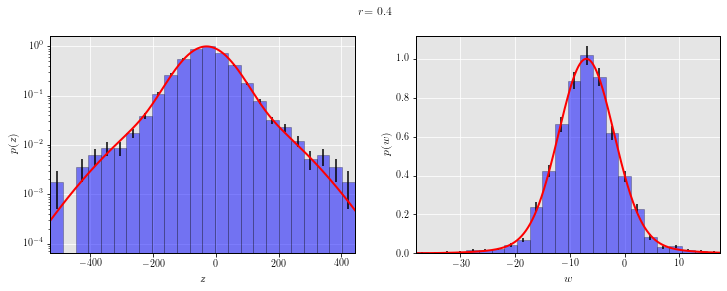

[-507.8736339  -427.0073255  -386.5741713  -346.1410171  -305.7078629
 -265.2747087  -224.8415545  -184.4084003  -143.9752461  -103.5420919
  -63.1089377   -22.67578349   17.75737071   58.19052491   98.62367911
  139.05683331  179.48998751  219.92314171  260.35629591  300.78945011
  341.22260431  381.65575851  422.08891271]


#,mid,num,err
0,-507.87363390418557,0.0017487492406075538,0.0012365524466284269
1,-427.00732550257453,0.0034974984812151076,0.0017487492406075538
2,-386.57417130176896,0.006120622342126438,0.0023133777980303212
3,-346.1410171009634,0.008743746203037767,0.002765015328404843
4,-305.7078629001579,0.008743746203037767,0.002765015328404843
...,...,...,...
18,260.3562959111197,0.012241244684252877,0.003271610256867287
19,300.7894501119252,0.0052462477218226606,0.002141771663784037
20,341.2226043127307,0.006120622342126438,0.0023133777980303212
21,381.6557585135363,0.0034974984812151076,0.0017487492406075538


In [60]:
import vaex

Nz = 5000
burn = 1000
z = chain[burn:, :, 0].flatten()
w = chain[burn:, :, 1].flatten()
for i, zbi in enumerate(zb[-1:]):
    mask = np.abs(z) < zbi
    z_sample = z[mask]
    w_sample = w[mask]
    index = np.random.randint(0, len(z_sample), Nz)
    z_sample = z_sample[index]
    w_sample = w_sample[index]

    znum, zedge = np.histogram(z_sample, bins=24)
    dz = zedge[1]-zedge[0]
    zmid = (zedge[:-1]+zedge[1:])/2
    mask = znum > 0
    znum = znum[mask]
    zmid = zmid[mask]
    zerr = np.sqrt(znum)
    max = znum.max()
    znum, zerr = znum/max, zerr/max
    z_tot = znum.sum()*dz
    zdata = (zmid, znum, zerr)
    zs = np.linspace(zedge.min()*1.1, zedge.max()*1.1, 1000)
    fz = Model.DM.fz(zs, theta, psi, zs[1]-zs[0])
    area = simps(fz, zs)
    fz = fz/(area)*z_tot
    max = fz.max()
    fz = fz/max
    znum, zerr = znum/max, zerr/max

    zbound = 50
    mask = np.abs(z_sample+zsun) < zbound
    w_sample = w_sample[mask]
    wnum, wedge = np.histogram(w_sample, bins=24)
    dw = wedge[1]-wedge[0]
    wmid = (wedge[:-1]+wedge[1:])/2
    mask = wnum > 0
    wnum = wnum[mask]
    wmid = wmid[mask]
    werr = np.sqrt(wnum)
    w_tot = wnum.sum()*dw
    ws = np.linspace(wedge.min(), wedge.max(), 1000)
    fw = Model.DM.fw(ws, theta, psi)
    area = simps(fw, ws)
    fw = fw/area*w_tot
    max = fw.max()
    fw = fw/max
    wnum, werr = wnum/max, werr/max
    wdata = (wmid, wnum, werr)

    # plot the data
    print(len(z_sample))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(zmid, znum, yerr=zerr, width=zedge[1]-zedge[0], color='b', alpha=0.5, ec="k")
    axes[0].plot(zs, fz, color='r', lw=2)
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$p(z)$')
    axes[0].set_xlim(zedge.min(), zedge.max())
    axes[0].set_yscale('log')
    axes[1].bar(wmid, wnum, yerr=werr, width=wedge[1]-wedge[0], color='b', alpha=0.5, ec="k")
    axes[1].plot(ws, fw, color='r', lw=2)
    axes[1].set_xlabel(r'$w$')
    axes[1].set_ylabel(r'$p(w)$')
    axes[1].set_xlim(wedge.min(), wedge.max())
    fig.suptitle(r'$r$= {}'.format(ratio[i]))
    plt.show()
    df_z = vaex.from_arrays(mid=zmid, num=znum, err=zerr)
    df_w = vaex.from_arrays(mid=wmid, num=wnum, err=werr)
    print(zmid)
    # df_z.export(join(root_dir, 'Data', 'MCMC-no', 'mock', 'data', 'z', f'z_{ratio[i]}.hdf5'), progress=True)
    # df_w.export(join(root_dir, 'Data', 'MCMC-no', 'mock', 'data' ,'z', f'w_{ratio[i]}.hdf5'), progress=True)
    # print(f"saved z_{ratio[i]}.hdf5 and w_{ratio[i]}.hdf5")
    break
df_z

In [26]:
psi[25:]

array([-7.        ,  1.60943791,  0.5       , -0.09531018,  0.1       ])

# different $N$, $z=z_b$

In [49]:
zb, ratio

(array([192.67, 289.74, 358.15, 407.68, 490.57, 545.22]),
 [0.4, 0.6, 0.8, 1.0, 1.5, 2.0])

In [50]:
theta

array([1.6e-02, 0.0e+00, 3.0e+01])

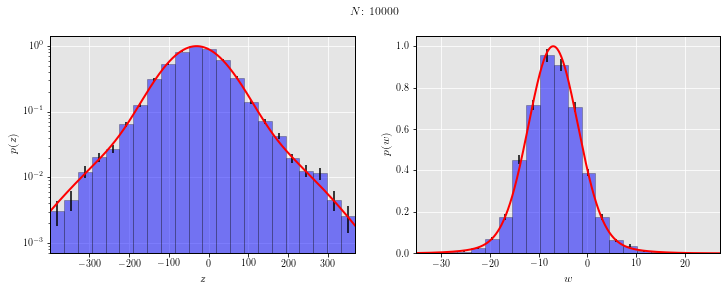

saved z_10000.hdf5 and w_10000.hdf5
10000 5179


In [54]:
import vaex

zb = 400

burn = 1000
z = chain[burn:, :, 0].flatten()
w = chain[burn:, :, 1].flatten()
mask = np.abs(z) < zb
z_s = z[mask]
w_s = w[mask]
# for Nz in [500, 1000, 5000, 10_000, 50_000, 100_000]:
# for Nz in [500, 1000, 1500, 2000, 5000, 10_000]:
for Nz in [10_000]:
    index = np.random.randint(0, len(z_s), Nz)
    z_sample = z_s[index]
    w_sample = w_s[index]
    znum, zedge = np.histogram(z_sample, bins=22)
    dz = zedge[1]-zedge[0]
    zmid = (zedge[:-1]+zedge[1:])/2
    mask = znum > 0
    znum = znum[mask]
    zmid = zmid[mask]
    zerr = np.sqrt(znum)
    max = znum.max()
    znum, zerr = znum/max, zerr/max
    z_tot = znum.sum()*dz
    zdata = (zmid, znum, zerr)
    zs = np.linspace(zedge.min()*1.1, zedge.max()*1.1, 1000)
    fz = Model.DM.fz(zs, theta, psi, zs[1]-zs[0])
    area = simps(fz, zs)
    fz = fz/(area)*z_tot
    max = fz.max()
    fz = fz/max
    znum, zerr = znum/max, zerr/max

    zbound = 50
    mask = np.abs(z_sample+zsun) < zbound
    w_sample = w_sample[mask]
    wnum, wedge = np.histogram(w_sample, bins=22)
    dw = wedge[1]-wedge[0]
    wmid = (wedge[:-1]+wedge[1:])/2
    mask = wnum > 0
    wnum = wnum[mask]
    wmid = wmid[mask]
    werr = np.sqrt(wnum)
    w_tot = wnum.sum()*dw
    ws = np.linspace(wedge.min(), wedge.max(), 1000)
    fw = Model.DM.fw(ws, theta, psi)
    area = simps(fw, ws)
    fw = fw/area*w_tot
    max = fw.max()
    fw = fw/max
    wnum, werr = wnum/max, werr/max
    wdata = (wmid, wnum, werr)

    # plot the data
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(zmid, znum, yerr=zerr, width=zedge[1]-zedge[0], color='b', alpha=0.5, ec="k")
    axes[0].plot(zs, fz, color='r', lw=2)
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$p(z)$')
    axes[0].set_xlim(zedge.min(), zedge.max())
    axes[0].set_yscale('log')
    axes[1].bar(wmid, wnum, yerr=werr, width=wedge[1]-wedge[0], color='b', alpha=0.5, ec="k")
    axes[1].plot(ws, fw, color='r', lw=2)
    axes[1].set_xlabel(r'$w$')
    axes[1].set_ylabel(r'$p(w)$')
    axes[1].set_xlim(wedge.min(), wedge.max())
    fig.suptitle(r'$N$: {}'.format(Nz))
    plt.show()
    df_z = vaex.from_arrays(mid=zmid, num=znum, err=zerr)
    df_w = vaex.from_arrays(mid=wmid, num=wnum, err=werr)
    # df_z.export(join(root_dir, 'Data', 'MCMC-no', 'mock','data', 'n', f'z_{Nz:05d}.hdf5'), progress=True)
    # df_w.export(join(root_dir, 'Data', 'MCMC-no', 'mock','data' ,'n', f'w_{Nz:05d}.hdf5'), progress=True)
    print(f"saved z_{Nz:05d}.hdf5 and w_{Nz:05d}.hdf5")
    print(Nz, len(w_sample))
    break
    

# for comparison model

In [100]:
from matplotlib import pyplot as plt
import numpy as np 
from os.path import join, abspath 
from hammer import Model
from time import time
import vaex
from scipy.integrate import simps
current = abspath("")
root_dir = abspath(join(current, '..', '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [101]:
from utils import plot_chain, plot_corner, style, concat

style()

In [97]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [6]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 1
a2 = 0.1
log_a = np.log(a1)
q_a = a2/a1

psi = concat(rhob, sigmaz, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

rhoDM = 0.02
log_nu0 = 0
zsun = 30

theta = concat(rhoDM, log_nu0, zsun)

((34,), array([3.43834171]))

In [98]:
# number of walkers
N = 16

z = np.random.randn(N)*200
w = np.random.randn(N)*20
dz = 0.5
pos = np.array([z, w]).T

nwalkers = pos.shape[0]
ndim = pos.shape[1]

In [99]:
t0 = time()
chain = Model.DM.sample(1_001_000, nwalkers, pos, theta, psi, 
                  dz=dz, verbose=True, parallel=True)
print(time() - t0, "s")
np.save(join(root_dir, 'Data', 'MCMC-no', 'mock',
        'data', 'mock', 'chain.npy'), chain[1000:, :, :])

1.6619856357574463 s


100%|██████████| 2/2 [00:00<00:00, 140.83it/s]


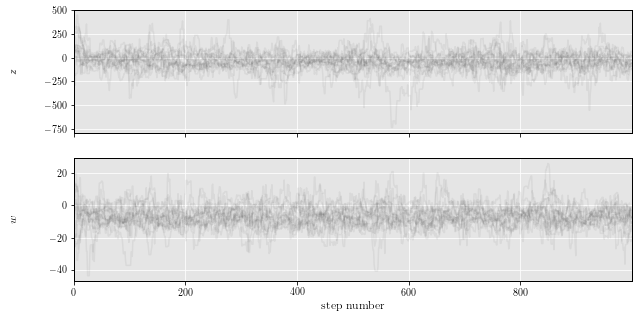

In [102]:
plot_chain(
    chain,
    labels=[r'$z$', r'$w$'],
    figsize=(10, 5),
    alpha=0.05,
) 

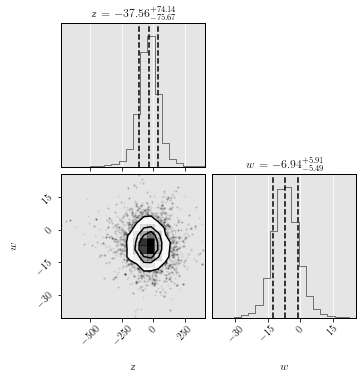

In [103]:
plot_corner(
    params=chain,
    labels=[r'$z$', r'$w$'],
    burn=100,
) 

In [7]:
chain = np.load(join(root_dir, 'Data', 'MCMC-no', 'mock', 'data', 'mock', 'chain.npy'))
chain.shape

(1000000, 16, 2)

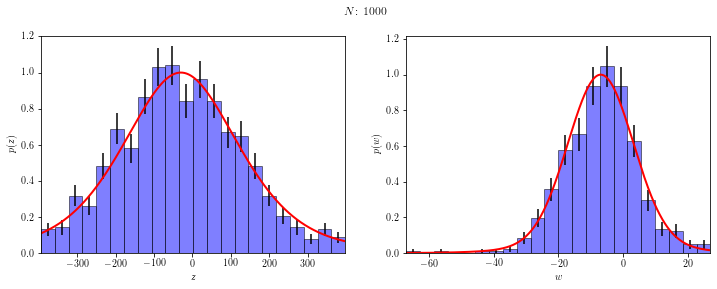

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_0001000.hdf5 and w_0001000.hdf5


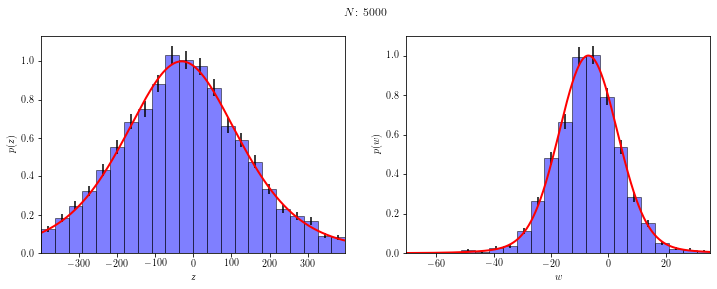

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 saved z_0005000.hdf5 and w_0005000.hdf5


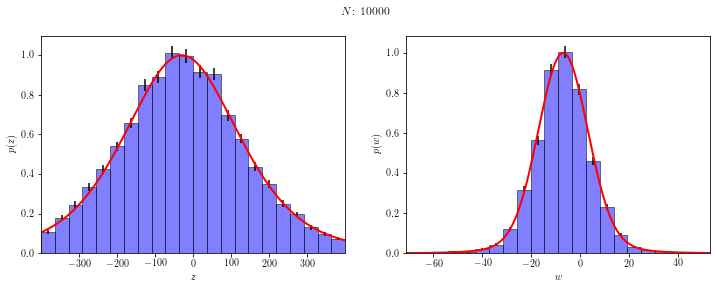

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_0010000.hdf5 and w_0010000.hdf5


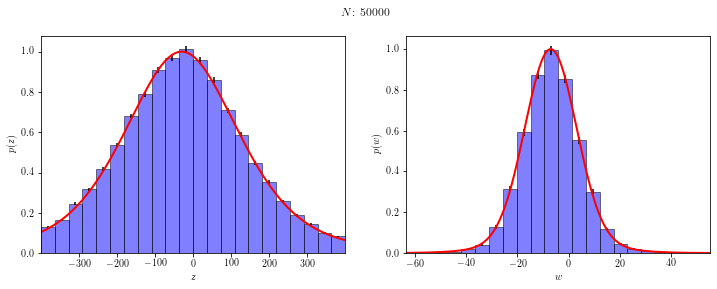

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_0050000.hdf5 and w_0050000.hdf5


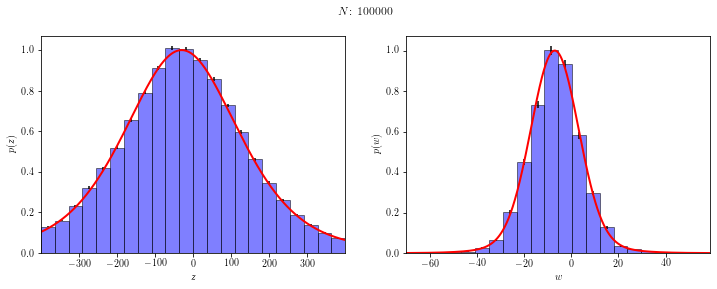

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_0100000.hdf5 and w_0100000.hdf5


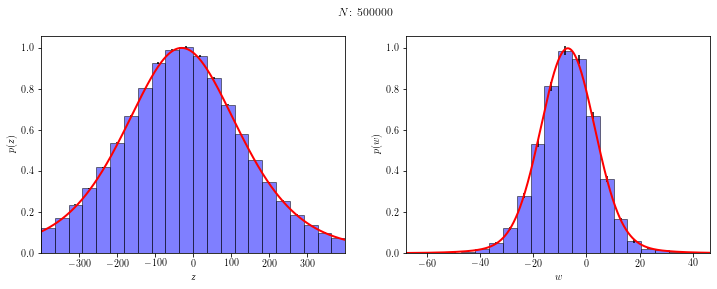

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_0500000.hdf5 and w_0500000.hdf5


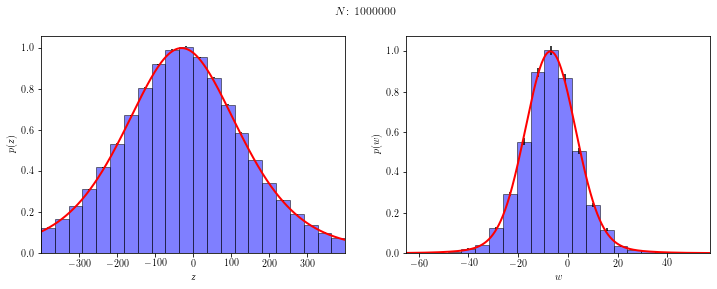

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved z_1000000.hdf5 and w_1000000.hdf5


In [10]:
import vaex

zb = 400.

burn = 1000
z = chain[burn:, :, 0].flatten()
w = chain[burn:, :, 1].flatten()
mask = np.abs(z) < zb
z_s = z[mask]
w_s = w[mask]
for Nz, Nw in [(1000, 500), (5000, 2500), (10_000, 5000), (50_000, 10_000), (100_000, 10_000), (500_000, 10_000), (1_000_000, 10_000)]:
    index = np.random.randint(0, len(z_s), Nz)
    z_sample = z_s[index]
    znum, zedge = np.histogram(z_sample, bins=22)
    dz = zedge[1]-zedge[0]
    zmid = (zedge[:-1]+zedge[1:])/2
    mask = znum > 0
    znum = znum[mask]
    zmid = zmid[mask]
    zerr = np.sqrt(znum)
    max = znum.max()
    znum, zerr = znum/max, zerr/max
    z_tot = znum.sum()*dz
    zdata = (zmid, znum, zerr)
    zs = np.linspace(zedge.min()*1.1, zedge.max()*1.1, 1000)
    fz = Model.DM.fz(zs, theta, zs[1]-zs[0])
    area = simps(fz, zs)
    fz = fz/(area)*z_tot
    max = fz.max()
    fz = fz/max
    znum, zerr = znum/max, zerr/max

    zbound = 50
    mask = np.abs(z_s) < zbound
    w_sample = w_s[mask]
    index = np.random.randint(0, len(w_sample), Nw)
    w_sample = w_sample[index]
    wnum, wedge = np.histogram(w_sample, bins=22)
    dw = wedge[1]-wedge[0]
    wmid = (wedge[:-1]+wedge[1:])/2
    mask = wnum > 0
    wnum = wnum[mask]
    wmid = wmid[mask]
    werr = np.sqrt(wnum)
    w_tot = wnum.sum()*dw
    ws = np.linspace(wedge.min(), wedge.max(), 1000)
    fw = Model.DM.fw(ws, theta)
    area = simps(fw, ws)
    fw = fw/area*w_tot
    max = fw.max()
    fw = fw/max
    wnum, werr = wnum/max, werr/max
    wdata = (wmid, wnum, werr)

    # plot the data
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(zmid, znum, yerr=zerr, width=zedge[1]-zedge[0], color='b', alpha=0.5, ec="k")
    axes[0].plot(zs, fz, color='r', lw=2)
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$p(z)$')
    axes[0].set_xlim(zedge.min(), zedge.max())
    axes[1].bar(wmid, wnum, yerr=werr, width=wedge[1]-wedge[0], color='b', alpha=0.5, ec="k")
    axes[1].plot(ws, fw, color='r', lw=2)
    axes[1].set_xlabel(r'$w$')
    axes[1].set_ylabel(r'$p(w)$')
    axes[1].set_xlim(wedge.min(), wedge.max())
    fig.suptitle(r'$N$: {}'.format(Nz))
    plt.show()
    df_z = vaex.from_arrays(mid=zmid, num=znum, err=zerr)
    df_w = vaex.from_arrays(mid=wmid, num=wnum, err=werr)
    df_z.export(join(root_dir, 'Data', 'MCMC-no', 'mock','data', 'mock', f'z_{Nz:07d}.hdf5'), progress=True)
    df_w.export(join(root_dir, 'Data', 'MCMC-no', 'mock','data' ,'mock', f'w_{Nz:07d}.hdf5'), progress=True)
    print(f"saved z_{Nz:07d}.hdf5 and w_{Nz:07d}.hdf5")
    # break